# I prepared a dataset of hospital facilities Asthma dismissal records and uploaded it to Carto. 
## download it with an SQL query. Use the function I provide below.
## The name of the DB is NYCAsthmasDismissals
## *within the SQLquery* group the data by zipcode.

In [88]:
import os
import numpy as np
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from scipy.spatial.distance import pdist, squareform
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import pylab as pl
%pylab inline

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

Populating the interactive namespace from numpy and matplotlib


In [16]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = 'SELECT COUNT(*), zipcodes FROM NYCAsthmasDismissals GROUP BY zipcodes'
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas.
# Merge the dataframe with the facility dismissals (the file you got on Carto)  joining on the zipcode and  use the zipcode geometry centers to extract the x and y coordinates of the zipcode center.

In [91]:
FilePath = os.getenv("PUIDATA")+"/HW11/"
os.chdir(FilePath)
zipNYC = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson")
# Change ColNames 
zipNYC = zipNYC.rename(columns={'postalCode': "zipcodes"})
zipNYC = zipNYC[['zipcodes', 'geometry', 'borough', 'PO_NAME']]
zipNYC.zipcodes = pd.to_numeric(zipNYC.zipcodes)
zipNYC = zipNYC.to_crs(epsg=2236)
zipNYC.head()

,zipcodes,geometry,borough,PO_NAME
0,11372,"POLYGON ((2632526.379016384 6052932.219743238,...",Queens,Jackson Heights
1,11004,"POLYGON ((2676531.420939567 6056890.612915368,...",Queens,Glen Oaks
2,11040,"POLYGON ((2679562.175423458 6053050.479516347,...",Queens,New Hyde Park
3,11426,"POLYGON ((2673084.746750208 6057959.536040894,...",Queens,Bellerose
4,11365,"POLYGON ((2649423.705504347 6046245.01344498, ...",Queens,Fresh Meadows


In [92]:
merged = zipNYC.merge(facilities, on="zipcodes",how="inner")
merged["centers"] = merged.centroid

In [93]:
merged = merged[["zipcodes","count","centers"]]

In [94]:
merged

,zipcodes,count,centers
0,11040,926,POINT (2678577.97719437 6056580.664981896)
1,11373,405,POINT (2630335.773761096 6048970.565126541)
2,11375,246,POINT (2639796.841926355 6043075.427831607)
3,11432,293,POINT (2654715.037406852 6042490.996427876)
4,11418,567,POINT (2644361.650169966 6035213.69306976)
5,11213,376,POINT (2616268.834274435 6022976.711539138)
6,11212,713,POINT (2622974.721016857 6020457.683927042)
7,11219,421,POINT (2600630.673675684 6007629.66209253)
8,10466,494,POINT (2634595.464853607 6105161.11507196)
9,10467,2164,POINT (2628379.045689929 6100000.963507032)


# Create a 3xN numpy array with x-location, y-location, number of dismissals

In [95]:
merged["x"] = merged.centers.map(lambda p: p.x)
merged["y"] = merged.centers.map(lambda p: p.y)

In [96]:
krigdata = merged.as_matrix(["x","y","count"])

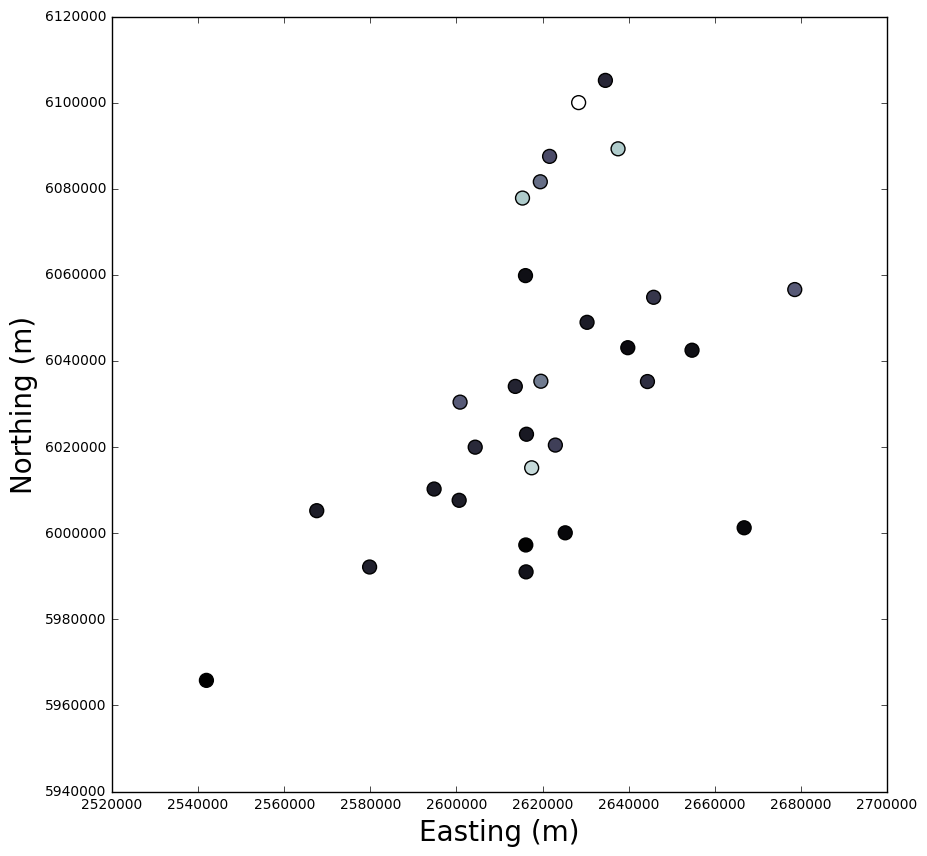

In [97]:
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)


### Figure 1: NYC Color Scaled Asthma Dismissal Rates by Zipcode Center Point
The above plot illustrated asthma dismissal rates by Zipcode. the color shows the counts of the facilities

In [100]:
# different variogram models
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )



def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct

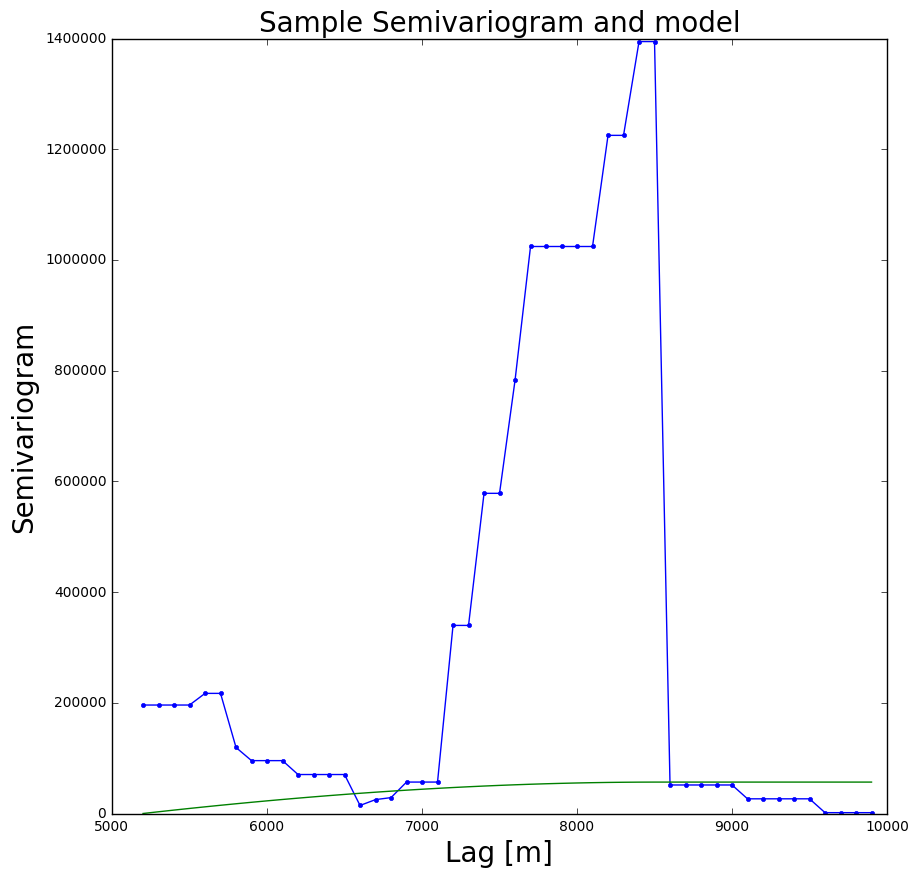

In [105]:
bw = 1000
pl.figure(figsize=(10,10))
sp = cvmodel( krigdata, model=spherical, 
             hs=np.arange(0,10000, 100 ), bw=bw)
#print sp(mysv[0])
sphere = sp(mysv[0])
plot( mysv[0], mysv[1], '.-' )
pl.plot(mysv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram and model', fontsize=20) ;

In [ ]:
## 